In [1]:
#imports
import os

import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import cv2

# from utils import load_data,tf_dataset,preprocess
from model_unet import simple_unet_model
from utils import *

2023-08-02 12:04:15.637371: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 12:04:16.190528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)  # Optional: List available GPUs

if tf.test.is_built_with_cuda() and len(physical_devices) > 0:
    device_details = tf.config.experimental.get_device_details(physical_devices[0])
    cudnn_version = device_details['cudnn_version']
    print("CuDNN version:", cudnn_version)
else:
    print("CuDNN is not available or no GPUs found.")

[]
CuDNN is not available or no GPUs found.


In [2]:
!nvidia-smi

Wed Aug  2 12:04:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P1000        Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8    N/A /  N/A |      4MiB /  4042MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#Set Paths 
IMAGES_PATH = '/home/pratikshinde/sugarcane/data/images/'
MASKS_PATH = '/home/pratikshinde/sugarcane/data/masks/'

In [4]:
#Hyperparameters
epochs = 200
batch_size = 8
HEIGHT = 512
WIDTH = 512

In [5]:
#Reading paths
image_list = read_paths(IMAGES_PATH)
mask_list = read_paths(MASKS_PATH)

In [6]:
len(image_list)

380

In [7]:
len(mask_list)

380

In [15]:
#  i = image_list[0].split('/')
# print(i[-1].split('.')[0])
mask_file_list =[]
for msk in mask_list:
    msk = msk.split('/')
    msk = msk[-1].split('.')[0]
    mask_file_list.append(msk)

img_file_list = []
for img in image_list:
    img = img.split('/')
    img = img[-1].split('.')[0]
    img_file_list.append(img)


In [16]:
# Elements in list2 but not in list1
elements_only_in_list1 = [element for element in img_file_list if element not in mask_file_list]

print("Elements only in list1:", elements_only_in_list1)

Elements only in list1: []


In [8]:
#Loading data
(train_x, train_y), (valid_x, valid_y) = load_data(image_list,mask_list)
print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)}")

#Creating dataset object
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size

Dataset: Train: 304 - Valid: 76


2023-08-02 12:04:36.833868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-02 12:04:36.860512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-02 12:04:36.861114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
# # Create a TensorFlow dataset
# dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))

# # Preprocess the dataset
# dataset = dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# dataset = dataset.shuffle(buffer_size=1000)
# dataset = dataset.batch(batch_size)
# dataset = dataset.repeat()
# dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# # Get an iterator over the dataset
# it = iter(dataset)

# # Iterate over the dataset using the iterator
# for batch in it:
#     # Process the batch
#     images, masks = batch

#     # Visualize the batch
#     for i in range(batch_size):
#         plt.subplot(2, batch_size, i+1)
#         plt.imshow(images[i])
#         plt.axis('off')
#         plt.subplot(2, batch_size, i+batch_size+1)
#         plt.imshow(masks[i], cmap='gray')
#         plt.axis('off')
#     plt.show()


In [9]:
train_dataset

In [11]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [12]:
from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [13]:
import segmentation_models as sm
#Create model instance
# model.load_weights('/workspace/AISSMS_Pomegranate_Demo/exp/weights/286.h5')
model = simple_unet_model(HEIGHT,WIDTH,3)


checkpoint_path = "/home/pratikshinde/sugarcane/exp/saved_weights/cp-{epoch:04d}.h5"   #"/workspace/sugarcane/exp1/saved_weights/cp-{epoch:04d}.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_freq=10,
                                                         verbose=1)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics

model.compile(optimizer="Adam",loss='binary_crossentropy', metrics = metrics)

In [27]:

model_history = model.fit(train_dataset,
                          steps_per_epoch=train_steps,
                          validation_data=valid_dataset,
                          validation_steps=valid_steps,
                          epochs=epochs,
                          callbacks=[checkpoint_callback])

Epoch 1/200


2023-07-28 12:39:33.881975: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-07-28 12:39:36.075917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-07-28 12:39:44.199362: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-28 12:39:44.199399: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-28 12:3

 9/38 [======>.......................] - ETA: 32s - loss: 14.7728 - iou_score: 0.0131 - f1-score: 0.0252
Epoch 1: saving model to /home/pratikshinde/sugarcane/exp/saved_weights/cp-0001.h5
19/38 [==============>...............] - ETA: 21s - loss: 8.9470 - iou_score: 0.0093 - f1-score: 0.0181
Epoch 1: saving model to /home/pratikshinde/sugarcane/exp/saved_weights/cp-0001.h5
29/38 [=====================>........] - ETA: 10s - loss: 6.4455 - iou_score: 0.0103 - f1-score: 0.0200
Epoch 1: saving model to /home/pratikshinde/sugarcane/exp/saved_weights/cp-0001.h5
38/38 [==============================] - 81s 1s/step - loss: 5.1795 - iou_score: 0.0106 - f1-score: 0.0206 - val_loss: 0.7425 - val_iou_score: 0.0011 - val_f1-score: 0.0022
Epoch 2/200
 1/38 [..............................] - ETA: 41s - loss: 1.2091 - iou_score: 0.0108 - f1-score: 0.0212
Epoch 2: saving model to /home/pratikshinde/sugarcane/exp/saved_weights/cp-0002.h5
11/38 [=======>......................] - ETA: 32s - loss: 0.8649 -

2023-07-28 12:43:19.297900: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-28 12:43:20.509748: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-28 12:43:22.994033: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-28 12:43:22.994313: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

38/38 [==============================] - 54s 1s/step - loss: 0.2064 - iou_score: 0.0105 - f1-score: 0.0206 - val_loss: 0.1440 - val_iou_score: 4.4427e-04 - val_f1-score: 8.8670e-04
Epoch 5/200
 7/38 [====>.........................] - ETA: 36s - loss: 0.1849 - iou_score: 0.0078 - f1-score: 0.0153
Epoch 5: saving model to /home/pratikshinde/sugarcane/exp/saved_weights/cp-0005.h5
17/38 [============>.................] - ETA: 26s - loss: 0.1806 - iou_score: 0.0071 - f1-score: 0.0141
Epoch 5: saving model to /home/pratikshinde/sugarcane/exp/saved_weights/cp-0005.h5
27/38 [====================>.........] - ETA: 13s - loss: 0.1858 - iou_score: 0.0073 - f1-score: 0.0143
Epoch 5: saving model to /home/pratikshinde/sugarcane/exp/saved_weights/cp-0005.h5
37/38 [============================>.] - ETA: 1s - loss: 0.1801 - iou_score: 0.0067 - f1-score: 0.0132
Epoch 5: saving model to /home/pratikshinde/sugarcane/exp/saved_weights/cp-0005.h5
38/38 [==============================] - 50s 1s/step - loss:

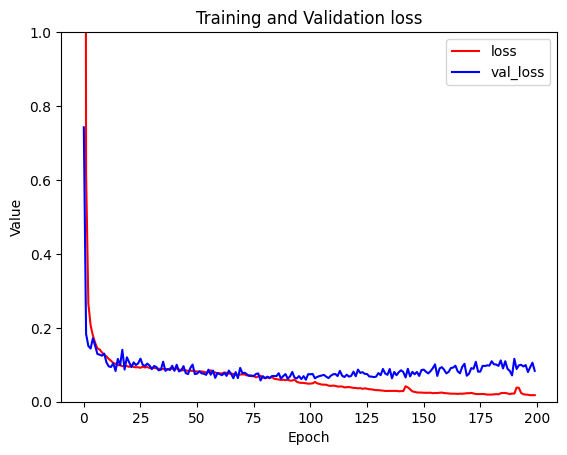

In [28]:
accuracy = model_history.history['loss']
val_accuracy = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, accuracy, 'r', label='loss')
plt.plot(model_history.epoch, val_accuracy, 'b', label='val_loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

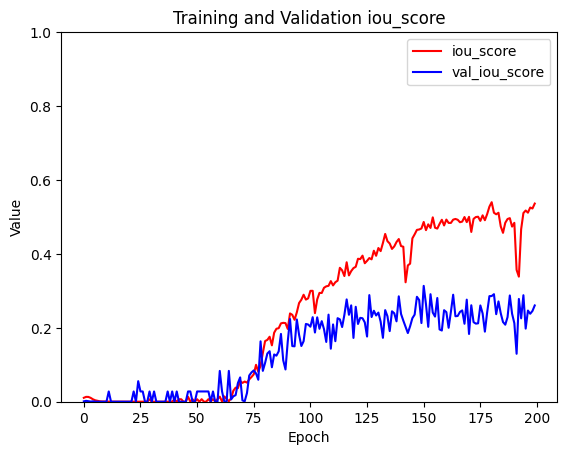

In [29]:
accuracy = model_history.history['iou_score']
val_accuracy = model_history.history['val_iou_score']

plt.figure()
plt.plot(model_history.epoch, accuracy, 'r', label='iou_score')
plt.plot(model_history.epoch, val_accuracy, 'b', label='val_iou_score')
plt.title('Training and Validation iou_score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

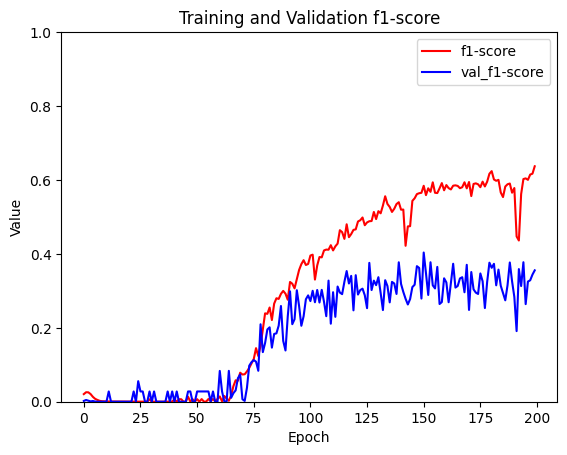

In [30]:
accuracy = model_history.history['f1-score']
val_accuracy = model_history.history['val_f1-score']

plt.figure()
plt.plot(model_history.epoch, accuracy, 'r', label='f1-score')
plt.plot(model_history.epoch, val_accuracy, 'b', label='val_f1-score')
plt.title('Training and Validation f1-score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
#model.save('/workspace/AISSMS_Pomegranate_Demo/exp/weights/450.h5')

In [ ]:
#Check the Inferencing Notebook Training done 

In [ ]:
#Inferencing

In [12]:
model = simple_unet_model(512,512,3)

In [13]:
model.load_weights('/home/pratikshinde/sugarcane/exp/saved_weights/cp-0200.h5')

In [14]:
len(valid_x)

76

1/1 [==============================] - 0s 17ms/step


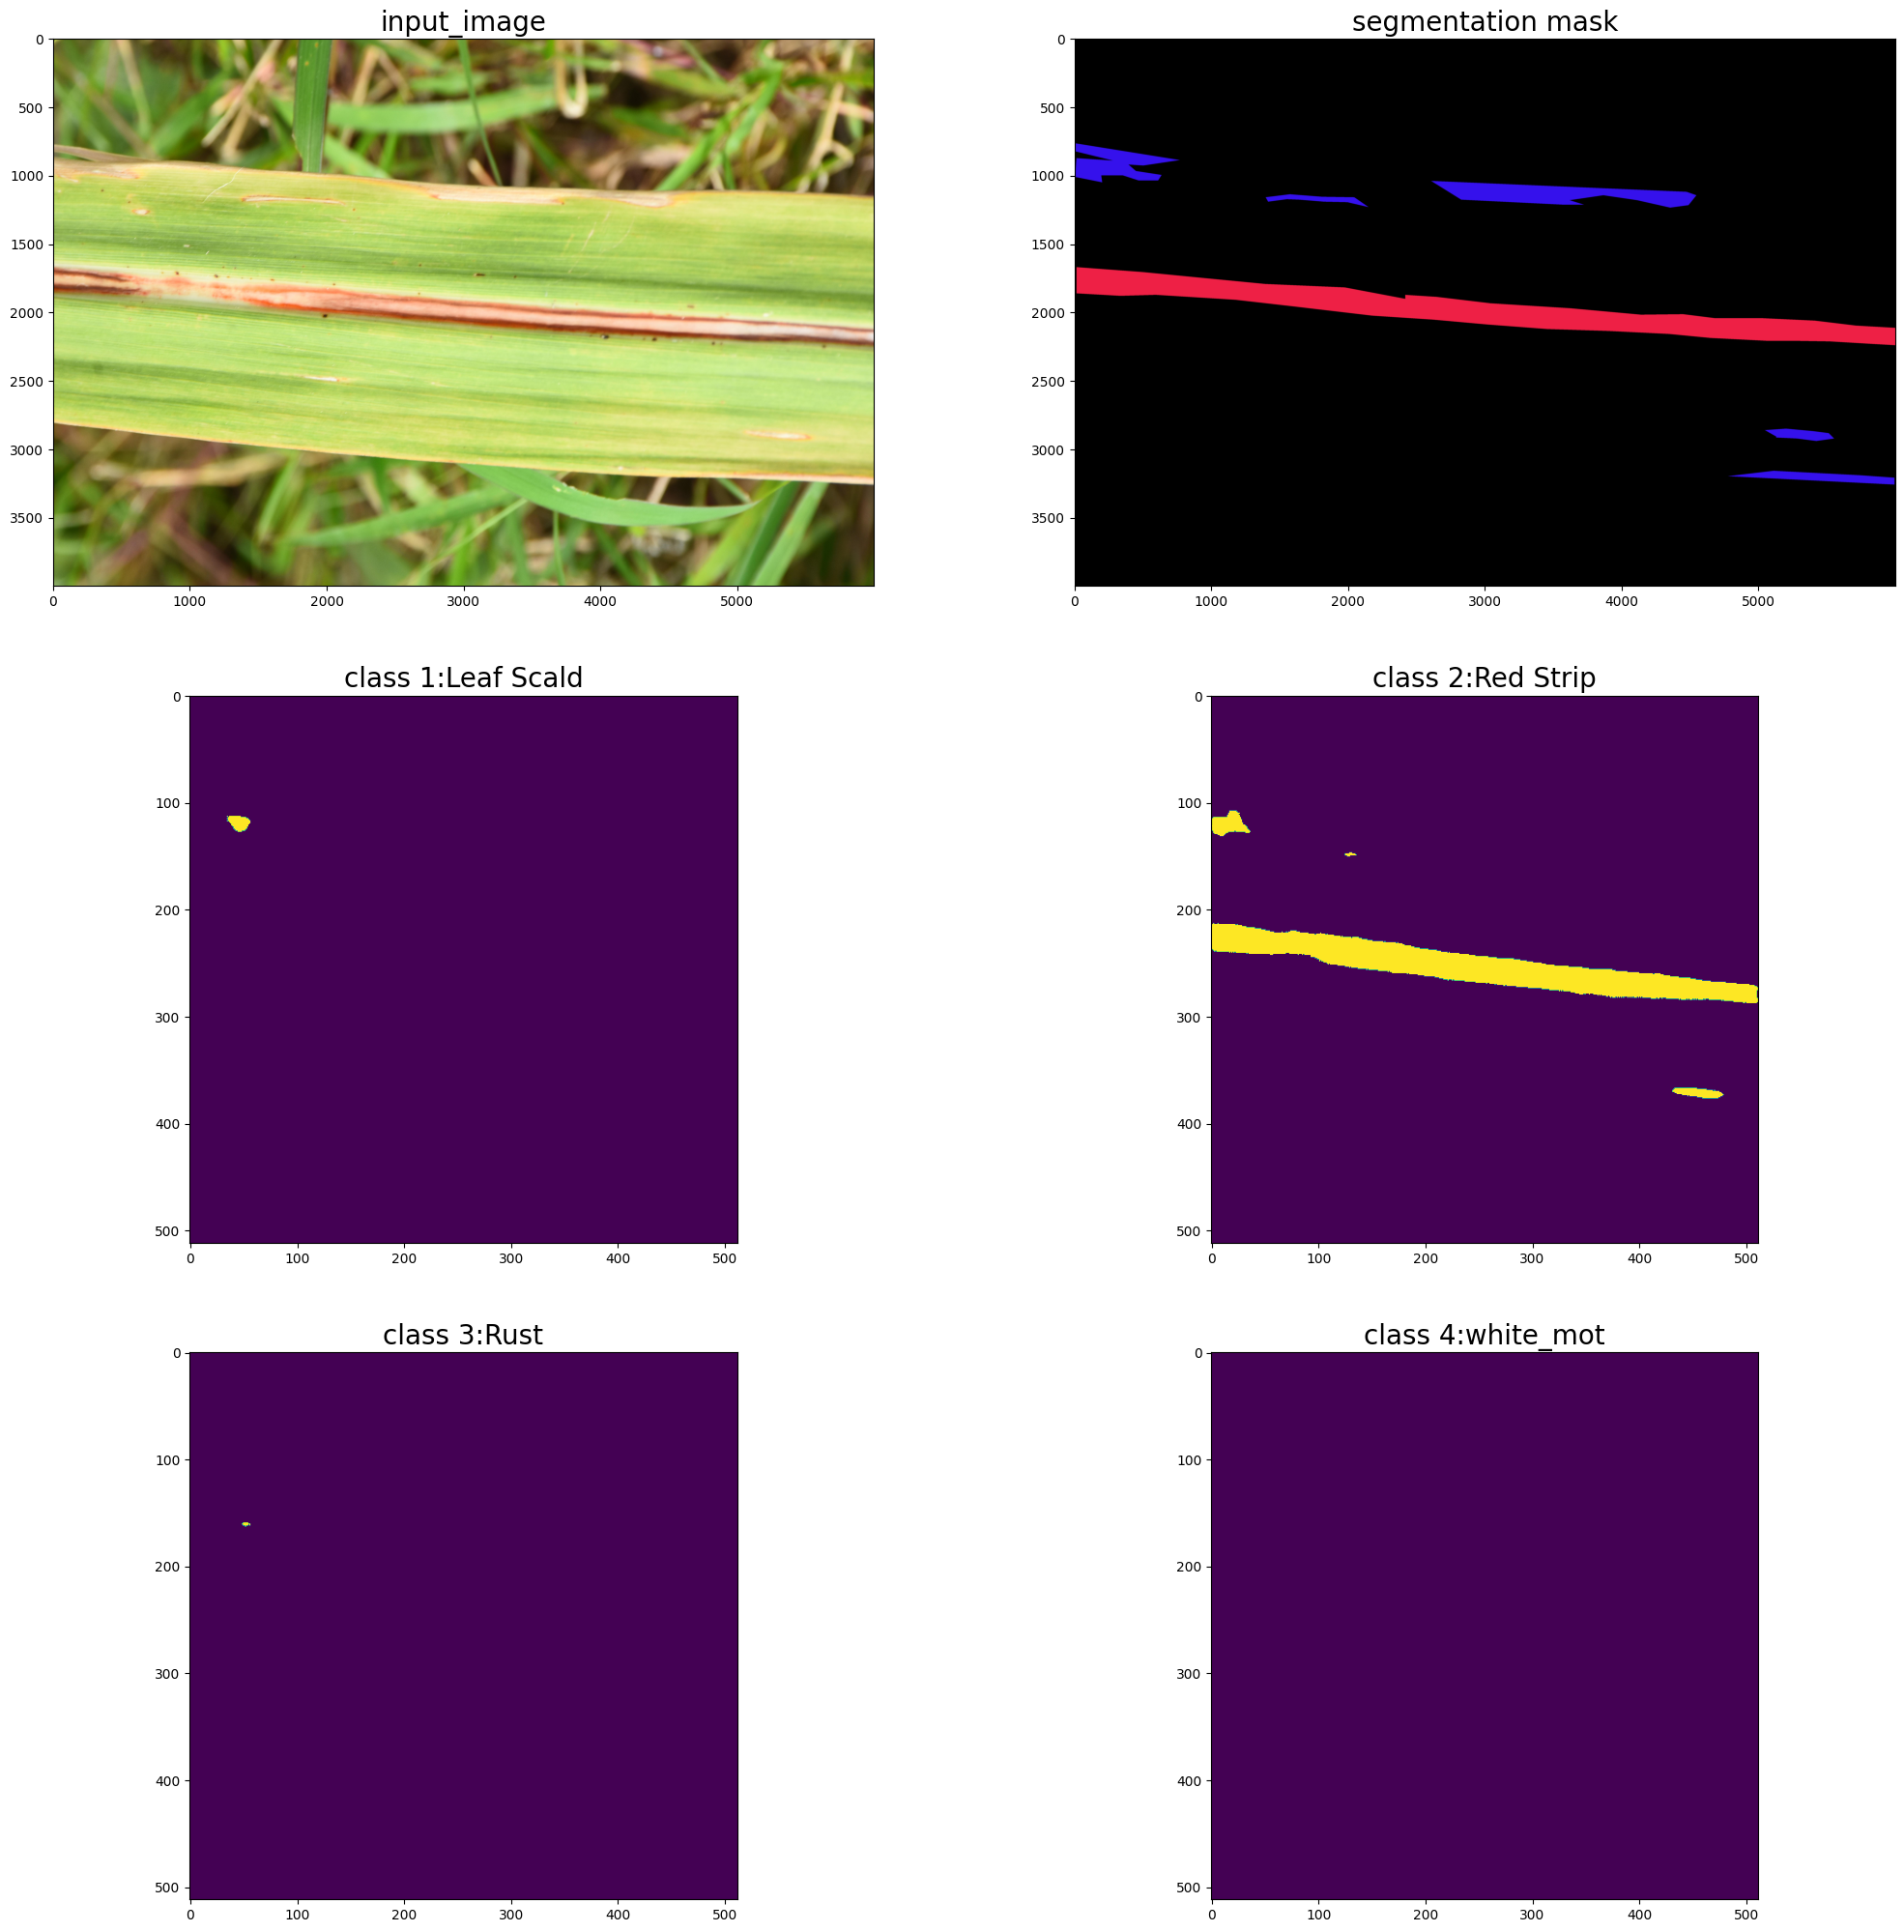

In [20]:
from utils import read_image,read_mask

fig, ax = plt.subplots(3,2 ,figsize=(25,25))

im_path = valid_x[12]
mask_path = valid_y[12]

i = 0

for im_path,mask_path in zip(valid_x,valid_y):

    input_tensor = read_image(im_path)
    output = model.predict(np.expand_dims(input_tensor,axis=0))
    output = output[0]
    output = np.where(output >0.5, 1, 0)

    image = cv2.imread(im_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask,cv2.COLOR_RGB2BGR)

    
    ax[0,0].imshow(image)
    ax[0,0].set_title('input_image',fontsize=20)

    ax[0,1].imshow(mask)
    ax[0,1].set_title('segmentation mask',fontsize=20)

    ax[1,0].imshow(output[:,:,0])
    ax[1,0].set_title('class 1:Leaf Scald',fontsize=20)

    ax[1,1].imshow(output[:,:,1])
    ax[1,1].set_title('class 2:Red Strip',fontsize=20)

    ax[2,0].imshow(output[:,:,2])
    ax[2,0].set_title('class 3:Rust',fontsize=20)

    ax[2,1].imshow(output[:,:,3])
    ax[2,1].set_title('class 4:white_mot',fontsize=20)

    # ax[2,2].imshow(output[:,:,4])
    # ax[2,2].set_title('Overlay',fontsize=20)
    
    plt.savefig('/home/pratikshinde/sugarcane/output/new/'+str(i)+'.jpeg')
    
    i +=1

In [ ]:
# from segmentation_mask_overlay import overlay_masks

# for im_path,mask_path in zip(valid_x,valid_y):
    
#     #Read Image
#     image = cv2.imread(im_path,cv2.IMREAD_GRAYSCALE)

#     #Infer
#     input_tensor = read_image(im_path)
#     output = model.predict(np.expand_dims(input_tensor,axis=0))
#     output = output[0]
#     output = cv2.resize(output,(image.shape[1],image.shape[0]),interpolation=cv2.INTER_BITS)
#     output = np.where(output >0.5, True, False)

#     #Plotting
#     masks = []
#     masks.append(output[:,:,0])
#     masks.append(output[:,:,1])
#     masks.append(output[:,:,2])

#     COLORMAP = [[53,12,235],[61,245,61],[228,23,55]]
#     mask_labels =['bacterial_fruit_blight','Alternaria_Fruit_Spot','pest_attack']

#     cmap = plt.cm.Set1([0,5,2])

#     # Laminate your image!
#     fig = overlay_masks(image, masks, labels=mask_labels, colors=cmap, mask_alpha=0.5)
    
    
#     # Do with that image whatever you want to do.
#     fig.savefig("/workspace/AISSMS_Pomegranate_Demo/exp3/overlayed_result3/"+im_path.split('/')[-1], bbox_inches="tight", dpi=300)

    
from segmentation_mask_overlay import overlay_masks

for im_path,mask_path in zip(valid_x,valid_y):
    
    #Read Image
    image = cv2.imread(im_path,cv2.IMREAD_GRAYSCALE)

    #Infer
    input_tensor = read_image(im_path)
    output = model.predict(np.expand_dims(input_tensor,axis=0))
    output = output[0]
    output = cv2.resize(output,(image.shape[1],image.shape[0]),interpolation=cv2.INTER_BITS)
    output = np.where(output >0.5, True, False)

    #Plotting
    masks = []
    masks.append(output[:,:,0])
    masks.append(output[:,:,1])
    masks.append(output[:,:,2])


#     COLORMAP = [[53,12,235],[61,245,61],[228,23,55]]
    mask_labels =['bacterial_fruit_blight','Alternaria_Fruit_Spot','pest_attack']
    cmap = plt.cm.Set1([0,5,2])

    # Laminate your image!
    fig = overlay_masks(image, masks, labels=mask_labels, colors=cmap, mask_alpha=0.5)
    
    
    # Do with that image whatever you want to do.
    fig.savefig("/workspace/AISSMS_EXP/exp2/overlay_results/"+im_path.split('/')[-1], bbox_inches="tight", dpi=300)